# Notes YEAST_COB_Batch constraint-based approach

In [1]:
run -i BPL_YEAST_COB_Batch_fmpy_explore.py

Linux - run FMU pre-compiled OpenModelica

Model for the process has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]

No processDiagram.png file in the FMU, but try the file on disk.


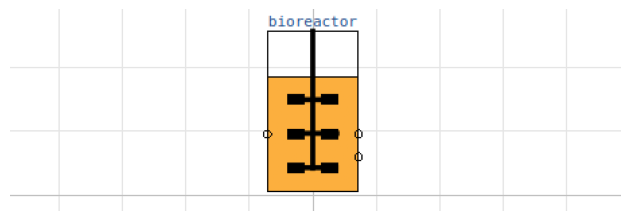

In [3]:
process_diagram()

## Try using LP in each step

In [4]:
from optlang import Model, Variable, Constraint, Objective

In [5]:
# Define culture constraint-based model
def culture(G, E):
    
    # LP calculation of the optimal qGr, qEr based on G and E values
    
    # - parameters
    qO2max = 6.9e-3; kog = 2.3; koe = 1.6; YGr = 3.5; YEr = 1.32; 
    alpha = 0.01; beta = 1.0
    
    # - transfer data from dynamic reactor model to static LP model
    qGr_opt = Variable('qGr_opt', lb=0)
    qEr_opt = Variable('qEr_opt', lb=0)

    # - LP model constraint and objective
    mu_max = Objective(YGr*qGr_opt + YEr*qEr_opt, direction='max')
    qO2lim = Constraint(kog*qGr_opt + koe*qEr_opt, ub=qO2max)
    qGlim = Constraint(qGr_opt, ub=alpha*max(0,G))
    qElim = Constraint(qEr_opt, ub=beta*max(0,E))

    # - put together the LP model
    yeast_model = Model(name='Yeast bottleneck model')
    yeast_model.objective = mu_max
    yeast_model.add(qO2lim)
    yeast_model.add(qGlim)
    yeast_model.add(qElim)

    # - do LP optimization
    yeast_model.optimize()
            
    return (yeast_model.objective.value, yeast_model.variables.qGr_opt.primal, yeast_model.variables.qEr_opt.primal, qO2lim.primal)

In [6]:
# Initialization
V_start=1.0
init(V_start=V_start, VX_start=V_start*2.0, VG_start=V_start*10, VE_start=V_start*3.0)

In [7]:
# Loop of simulations
t_final = 8.0
t_samp = 0.0333
n_samp = t_final/t_samp + 1

LOG_ASSERT        | warning | [/media/sf_Modelica/Library/BioprocessLibrary-2.3.1 MSL 4 .1.0/BPL/EquipmentLib.mo:79:3-80:80:writable]
|                 | |       | The following assertion has been violated at time 6.726600
|                 | |       | ((bioreactor.m_start[3] >= 0.0)) --> "Variable violating min constraint: 0.0 <= bioreactor.m_start[3], has value: -0.0437828"
LOG_ASSERT        | warning | [/media/sf_Modelica/Library/BioprocessLibrary-2.3.1 MSL 4 .1.0/BPL/EquipmentLib.mo:64:3-64:72:writable]
|                 | |       | The following assertion has been violated at time 6.726600
|                 | |       | ((bioreactor.c[3] >= 0.0)) --> "Variable violating min constraint: 0.0 <= bioreactor.c[3], has value: -0.0437828"
LOG_ASSERT        | warning | [/media/sf_Modelica/Library/BioprocessLibrary-2.3.1 MSL 4 .1.0/BPL/EquipmentLib.mo:84:3-84:72:writable]
|                 | |       | The following assertion has been violated at time 6.726600
|                 | |       | (

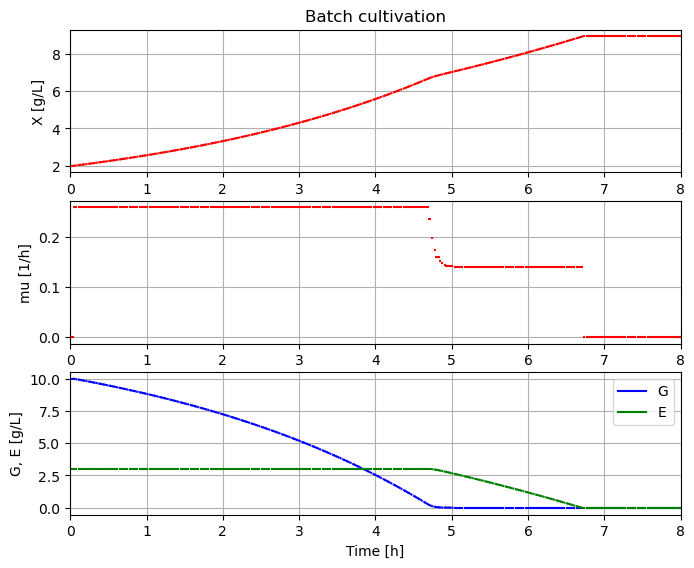

In [8]:
# Simulate n sample steps
newplot(title='Batch cultivation', plotType='TimeSeries2') 
ax1.set_xlim([0, t_final]); ax2.set_xlim([0, t_final]); ax3.set_xlim([0, t_final])

simu(t_samp, options=opts_fast)
for i in range(int(n_samp)): 
    (mum_opt, qGr_opt, qEr_opt, qO2_opt) = culture(sim_res['bioreactor.c[2]'][-1], sim_res['bioreactor.c[3]'][-1])
    par(mum=mum_opt, qGr=qGr_opt, qEr=qEr_opt, qO2=qO2_opt)
    simu(t_samp, 'cont', options=opts_fast)

In [9]:
system_info()


System information
 -OS: Linux
 -Python: 3.12.11
 -Scipy: not installed in the notebook
 -FMPy: 0.3.26
 -FMU by: OpenModelica Compiler OpenModelica 1.26.0~dev-200-gcb3254b
 -FMI: 2.0
 -Type: ME
 -Name: BPL_YEAST_COB.Batch
 -Generated: 2025-07-23T14:19:38Z
 -MSL: 4.1.0
 -Description: Bioprocess Library version 2.3.1
 -Interaction: FMU-explore for FMPy version 1.0.1


In [10]:
!conda list optlang

# packages in environment at /home/janpeter/miniconda3/envs/fmpy:
#
# Name                     Version          Build            Channel
optlang                    1.8.3            pyhd8ed1ab_0     conda-forge


In [11]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 24.04.3 LTS
Release:	24.04
Codename:	noble
